In [2]:
import os 
os.chdir("..")
import numpy as np
import sympy
import cirq
import tensorflow_quantum as tfq
from tqdm import tqdm
import tensorflow as tf

from utilities.variational import VQE
from utilities.circuit_basics import Evaluator
from utilities.idinserter import IdInserter
from utilities.simplifier import Simplifier
from utilities.unitary_killer import UnitaryMurder

n_qubits = 4
qlr = 0.01
qepochs = 10**3
verbose=0
g=1
J=0
noise=0.0
problem="TFIM"
vqe_handler = VQE(n_qubits=n_qubits, lr=qlr, epochs=qepochs, patience=100,
                  random_perturbations=True, verbose=verbose, g=g, J = J, problem=problem)

iid = IdInserter(n_qubits=n_qubits)
Simp = Simplifier(n_qubits=n_qubits)
killer = UnitaryMurder(vqe_handler)
indexed_circuit=[vqe_handler.number_of_cnots+k for k in range(vqe_handler.n_qubits,2*vqe_handler.n_qubits)]


circuit, symbols, idx_symbols = vqe_handler.give_circuit(indexed_circuit)


In [3]:
pauls = [cirq.X, cirq.Y, cirq.Z]
circuit_res = cirq.resolve_parameters(circuit, {s:0 for s,k in zip(symbols, range(len(symbols)))})
p=0.01
cbatch = []
totals=10**3
for k in range(totals):
    circ = circuit.copy()
    if k<int((1-p)*totals):
        cbatch.append(circ)
    elif int((1-p)*totals)<=k:
        which = np.random.choice(range(3), 1)[0]
        gate = pauls[which]
        for q in vqe_handler.qubits:
            circ.append(gate.on(q))
        cbatch.append(circ)

In [4]:
len(cbatch)

1000

In [5]:
circuit_input = tf.keras.Input(shape=(), dtype=tf.string)
output = tfq.layers.Expectation()(circuit_input, symbol_names=symbols, operators=tfq.convert_to_tensor([vqe_handler.observable]*1000),
        initializer=tf.keras.initializers.RandomUniform(minval=-np.pi, maxval=np.pi))

model = tf.keras.Model(inputs=circuit_input, outputs=output)
adam = tf.keras.optimizers.Adam(learning_rate=vqe_handler.lr)
model.compile(optimizer=adam, loss='mse')
tfqcircuit = tfq.convert_to_tensor(cbatch)
qoutput = tf.ones((10**3, 1))*vqe_handler.lower_bound_Eg
from datetime import datetime
now = datetime.now()
h=model.fit(x=tfqcircuit, y=qoutput, batch_size=10**3, epochs=10,
          verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=vqe_handler.patience, mode="min", min_delta=10**-3)])
print(datetime.now()-now)

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 6407.6597
Epoch 2/10
1000/1000 [==============================] - 0s 155us/sample - loss: 6407.0381
Epoch 3/10
1000/1000 [==============================] - 0s 153us/sample - loss: 6406.4087
Epoch 4/10
1000/1000 [==============================] - 0s 159us/sample - loss: 6405.7871
Epoch 5/10
1000/1000 [==============================] - 0s 160us/sample - loss: 6405.1440
Epoch 6/10
1000/1000 [==============================] - 0s 157us/sample - loss: 6404.5137
Epoch 7/10
1000/1000 [==============================] - 0s 153us/sample - loss: 6403.8921
Epoch 8/10
1000/1000 [==============================] - 0s 157us/sample - loss: 6403.2695
Epoch 9/10
1000/1000 [==============================] - 0s 153us/sample - loss: 6402.6372
Epoch 10/10
1000/1000 [==============================] - 0s 156us/sample - loss: 6401.9946
0:00:02.911785


In [7]:
import matplotlib.pyplot as plt

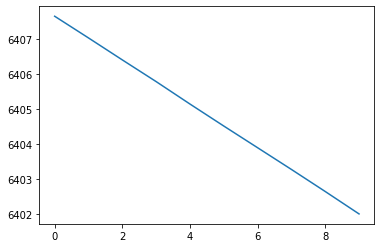

In [8]:
plt.plot(h.history["loss"])

In [12]:
tf.tf.math.reduce_mean(model(tfqcircuit))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0075935707>